# Anomaly detection in payments using XGBoost binary classification

In [3]:
import boto3
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer
from sagemaker import get_execution_role

In [4]:
bucket = 'anomaly-credit-cards'
prefix = 'sagemaker/supervised/xgboost'
role = get_execution_role()

In [40]:
df = pd.read_csv('paysim1.zip', compression='zip')
print(df.columns)
df.head()

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [54]:
df['dest_is_merchant'] = (df['nameDest'].astype(str).str[0] == 'M')*1
df['orig_delta'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_delta'] = df['oldbalanceDest'] - df['newbalanceDest']
df['orig_mismatch'] = (df['amount'] != abs(df['orig_delta']))*1
df['dest_mismatch'] = (df['amount'] != abs(df['dest_delta']))*1

In [69]:
df = df.drop(index=df.query('isFlaggedFraud == 1').index)
df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud', 'step', 'oldbalanceOrg', 'oldbalanceDest', 'newbalanceOrig', 'newbalanceDest'])
df.head()

,type,amount,isFraud,orig_delta,dest_delta,orig_mismatch,dest_mismatch,dest_is_merchant
0,PAYMENT,9839.64,0,9839.64,0.0,1,1,1
1,PAYMENT,1864.28,0,1864.28,0.0,1,1,1
2,TRANSFER,181.00,1,181.00,0.0,0,1,0
3,CASH_OUT,181.00,1,181.00,21182.0,0,1,0
4,PAYMENT,11668.14,0,11668.14,0.0,0,1,1


In [70]:
def get_fraction(numerator,denominator):
    percentage = 100.0*numerator/denominator
    return f"{percentage:.2f}% ".rjust(8) + "-" + f"{numerator} / {denominator}".rjust(20)

In [71]:
mismatch_df = df.query('orig_mismatch == 1 | dest_mismatch == 1')

total_transactions = len(df.index)
total_mismatch = len(mismatch_df.index)
total_frauds = len(df.query('isFraud == 1').index)
orig_mismatch_total = len(mismatch_df.query('orig_mismatch == 1').index)
dest_mismatch_total = len(mismatch_df.query('dest_mismatch == 1').index)
orig_mismatch_frauds = len(mismatch_df.query('orig_mismatch == 1 & (isFraud == 1)').index)
dest_mismatch_frauds = len(mismatch_df.query('dest_mismatch == 1 & (isFraud == 1)').index)
mismatch_frauds = len(mismatch_df.query('isFraud == 1').index)

print(get_fraction(total_mismatch, total_transactions), "total mismatches")
print(get_fraction(orig_mismatch_total, total_transactions), "mismatched origins")
print(get_fraction(dest_mismatch_total, total_transactions), "mismatched destinations\n")
print(get_fraction(mismatch_frauds, total_frauds), "of frauds are mismatched")
print(get_fraction(orig_mismatch_frauds, total_frauds), "of frauds have mismatched origin")
print(get_fraction(dest_mismatch_frauds, total_frauds), "of frauds have mismatched destination")
print(get_fraction(mismatch_frauds, total_mismatch), "of mismatches are frauds")


 98.00% -   6235226 / 6362604 total mismatches
 85.40% -   5433509 / 6362604 mismatched origins
 85.05% -   5411554 / 6362604 mismatched destinations

 73.64% -         6036 / 8197 of frauds are mismatched
  0.65% -           53 / 8197 of frauds have mismatched origin
 73.51% -         6026 / 8197 of frauds have mismatched destination
  0.10% -      6036 / 6235226 of mismatches are frauds


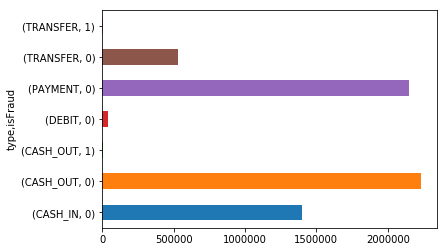

In [38]:
df.groupby(['type','isFraud']).count()['amount'].plot.barh()

In [72]:
df.head()

,type,amount,isFraud,orig_delta,dest_delta,orig_mismatch,dest_mismatch,dest_is_merchant
0,PAYMENT,9839.64,0,9839.64,0.0,1,1,1
1,PAYMENT,1864.28,0,1864.28,0.0,1,1,1
2,TRANSFER,181.00,1,181.00,0.0,0,1,0
3,CASH_OUT,181.00,1,181.00,21182.0,0,1,0
4,PAYMENT,11668.14,0,11668.14,0.0,0,1,1


In [73]:
model_data = pd.get_dummies(df)
model_data = pd.concat([model_data['isFraud'], model_data.drop(['isFraud'], axis=1)], axis=1)
model_data.head()

,isFraud,amount,orig_delta,dest_delta,orig_mismatch,dest_mismatch,dest_is_merchant,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,9839.64,9839.64,0.0,1,1,1,0,0,0,1,0
1,0,1864.28,1864.28,0.0,1,1,1,0,0,0,1,0
2,1,181.00,181.00,0.0,0,1,0,0,0,0,0,1
3,1,181.00,181.00,21182.0,0,1,0,0,1,0,0,0
4,0,11668.14,11668.14,0.0,0,1,1,0,0,0,1,0


In [74]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=707), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [75]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Train


In [77]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

In [78]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

### Using default hyper parameters shamelessly stolen from Amazon
https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.ipynb

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [110]:
sess = sagemaker.Session()

job_name_prefix = 'anomaly-xgboost'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(eval_metric='auc',
                        max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation},
        job_name=job_name
       ) 

INFO:sagemaker:Creating training-job with name: anomaly-xgboost-2018-12-21-16-54-44


2018-12-21 16:54:44 Starting - Starting the training job...
2018-12-21 16:54:46 Starting - Launching requested ML instances......
2018-12-21 16:55:50 Starting - Preparing the instances for training......
2018-12-21 16:57:07 Downloading - Downloading input data...
2018-12-21 16:57:33 Training - Training image download completed. Training in progress.
Arguments: train
[2018-12-21:16:57:33:INFO] Running standalone xgboost training.
[2018-12-21:16:57:33:INFO] File size need to be processed in the node: 266.68mb. Available memory size in the node: 8373.71mb
[2018-12-21:16:57:33:INFO] Determined delimiter of CSV input is ','
[16:57:33] S3DistributionType set as FullyReplicated
[16:57:35] 4453822x11 matrix with 48992042 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-12-21:16:57:35:INFO] Determined delimiter of CSV input is ','
[16:57:35] S3DistributionType set as FullyReplicated
[16:57:35] 1272521x11 matrix with 13997731 entries loaded from /opt/ml/in

---
# Deploy

In [113]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2018-12-21-17-05-03-766
INFO:sagemaker:Creating endpoint with name anomaly-xgboost-2018-12-21-16-54-44


--------------------------------------------------------------!

In [131]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: anomaly-xgboost-2018-12-21-16-54-44


## Test

In [114]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [115]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])

In [116]:
conf_matrix = pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])
conf_matrix

predictions,0.0,1.0
actual,,
0,635441,11
1,241,568


In [117]:
tp = conf_matrix[1][1]
tn = conf_matrix[0][0]
fp = conf_matrix[1][0]
fn = conf_matrix[0][1]

print(f' accuracy = {100.0 * (tp + tn)/(tp + tn + fp + fn):.2f}%')
print(f'precision = {100.0 * tp / (tp + fp):.2f}%')
print(f'   recall = {100.0 * tp / (tp + fn):.2f}%')

 accuracy = 99.96%
precision = 98.10%
   recall = 70.21%


---
# Do it again with hyper-parameter tuning

In [119]:
sess_hpt = sagemaker.Session()

job_name_prefix_hpt = 'anomaly-xgboost-hpt'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name_hpt = job_name_prefix_hpt + timestamp

xgb_hpt = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=4, 
                                    train_instance_type='ml.m4.2xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess_hpt)
xgb_hpt.set_hyperparameters(
                        eval_metric='auc',
                        gamma=4,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

In [120]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(1, 10)}

In [121]:
tuner = HyperparameterTuner(xgb_hpt,
                            objective_metric_name='validation:auc',
                            base_tuning_job_name=job_name_hpt,
                            hyperparameter_ranges=hyperparameter_ranges,
                            max_jobs=18,
                            max_parallel_jobs=3)

tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

INFO:sagemaker:Creating hyperparameter tuning job with name: anomaly-xgboost-hpt--181221-1713


In [126]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

## Deploy again

In [132]:
xgb_hpt_predictor = tuner.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

2018-12-21 17:44:08 Starting - Preparing the instances for training
2018-12-21 17:44:08 Downloading - Downloading input data
2018-12-21 17:44:08 Training - Training image download completed. Training in progress.
2018-12-21 17:44:08 Uploading - Uploading generated training model
2018-12-21 17:44:08 Completed - Training job completed

INFO:sagemaker:Creating model with name: xgboost-2018-12-21-18-06-55-834


Arguments: train
[2018-12-21:17:41:22:INFO] Running distributed xgboost training.
Arguments: train
[2018-12-21:17:41:25:INFO] Running distributed xgboost training.
Arguments: train
[2018-12-21:17:41:22:INFO] Running distributed xgboost training.
[2018-12-21:17:41:26:INFO] Number of hosts: 4, master IP address: 10.44.0.4, host IP address: 10.44.0.4.
[2018-12-21:17:41:26:INFO] Finished Yarn configuration files setup.

[2018-12-21:17:41:25:INFO] Number of hosts: 4, master IP address: 10.44.0.4, host IP address: 10.32.0.5.
[2018-12-21:17:41:25:INFO] Finished Yarn configuration files setup.

starting datanode, logging to /opt/amazon/hadoop/logs/hadoop--datanode-aws.out
[2018-12-21:17:41:25:INFO] Number of hosts: 4, master IP address: 10.44.0.4, host IP address: 10.36.0.4.
[2018-12-21:17:41:25:INFO] Finished Yarn configuration files setup.

starting datanode, logging to /opt/amazon/hadoop/logs/hadoop--datanode-aws.out
Arguments: train
[2018-12-21:17:41:24:INFO] Running distributed xgboost tr

INFO:sagemaker:Creating endpoint with name anomaly-xgboost-hpt--181221-1713-015-5bde2681


--------------------------------------------------------------------------!

In [ ]:
#sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)

## Test again

In [133]:
xgb_hpt_predictor.content_type = 'text/csv'
xgb_hpt_predictor.serializer = csv_serializer
xgb_hpt_predictor.deserializer = None

def hpt_predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_hpt_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = hpt_predict(test_data.as_matrix()[:, 1:])

In [134]:
hpt_conf_matrix = pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])
hpt_conf_matrix

predictions,0.0,1.0
actual,,
0,635443,9
1,240,569


In [137]:
tp = hpt_conf_matrix[1][1]
tn = hpt_conf_matrix[0][0]
fp = hpt_conf_matrix[1][0]
fn = hpt_conf_matrix[0][1]
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(f' accuracy = {100.0 * (tp + tn)/(tp + tn + fp + fn):.2f}%')
print(f'precision = {100.0 * precision:.2f}%')
print(f'   recall = {100.0 * recall:.2f}%')
print(f' F1 score = {100.0 * precision * recall / (precision + recall):.2f}')

 accuracy = 99.96%
precision = 98.44%
   recall = 70.33%
 F1 score = 41.02


In [150]:
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns

label_map = {0:'Normal', 1:'Fraud'}

def evaluate_metrics(test_preds, test_labels):
    # calculate overall scored
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]
    f1_macro = f1_score(test_labels, test_preds, average='macro')
    
    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'], normalize='index')

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
    ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    ax.set_ylabel('')
    print('Accuracy: {:.10f}'.format(accuracy))
    print('F1 Score: {:.3f}'.format(f1_macro))

Accuracy: 0.9996086512
F1 Score: 0.910


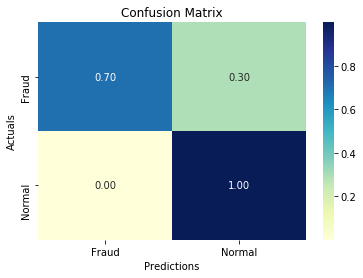

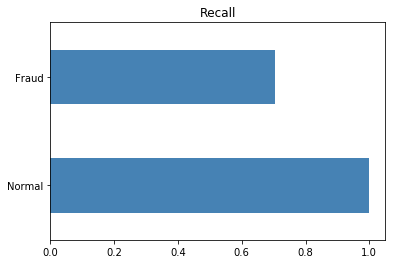

In [151]:
evaluate_metrics(np.round(predictions), test_data['isFraud'])

Text(0.5,1,'2-class Precision-Recall curve: AP=0.80')

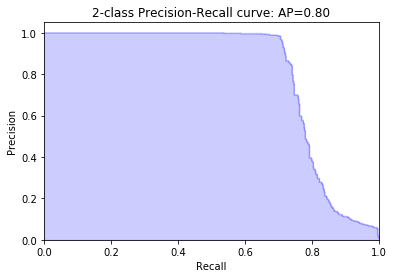

In [162]:
from sklearn.utils.fixes import signature
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(test_data['isFraud'], predictions)

precision, recall, _ = precision_recall_curve(test_data['isFraud'], predictions)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))